In [16]:
# Import the packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
tf.random.set_seed(1)

In [4]:
df = pd.read_excel('/content/drive/MyDrive/Github/m_tech/Datasets/input.xlsx')

In [5]:
df.head()

,Date,SalesVolume
0,1995-01-01,47639
1,1995-02-01,47880
2,1995-03-01,67025
3,1995-04-01,56925
4,1995-05-01,64192


In [6]:
df = df.dropna()
df = df.sort_values('Date').set_index('Date')

In [7]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(df.values.reshape(len(df), 1))
series = pd.DataFrame(scaled)

In [8]:
def create_samples(window_size,series):
  series_s = series.copy()
  for i in range(window_size):
    series = pd.concat([series, series_s.shift(-(i+1))], axis = 1)
  series.dropna(axis=0, inplace=True)
  return series

In [9]:
lstm_input = create_samples(12, series)

In [10]:
def create_train_samples(sample_series):
  train_X = sample_series.iloc[:,:-1].values
  train_y = sample_series.iloc[:,-1].values
  train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)
  return train_X, train_y

In [11]:
train_X, train_y = create_train_samples(lstm_input)

In [34]:
def base_model(train_X):
  model_arch = Sequential()
  model_arch.add(LSTM(128, activation= 'relu', return_sequences= True,input_shape=(train_X.shape[1], 1),
                 kernel_initializer= 'lecun_uniform',kernel_regularizer= 'l2'))
  model_arch.add(LSTM(64, activation= 'relu', return_sequences= True,
                 kernel_initializer= 'lecun_uniform',kernel_regularizer= 'l2'))
  model_arch.add(LSTM(32, activation= 'relu', return_sequences= False,
                 kernel_initializer= 'lecun_uniform',kernel_regularizer= 'l2'))
  model_arch.add(Dense(1))
  opt = tf.keras.optimizers.Adam(learning_rate= 0.001)
  model_arch.compile(loss="mse", optimizer= opt,metrics=['accuracy'])
  return model_arch

In [35]:
univariate_forecast_model = base_model(train_X)

In [38]:
def fit_model(model_arch, train_X, train_y, batch_size):
  history = model_arch.fit(train_X,
                 train_y,
                 batch_size=batch_size,
                 epochs=100,
                 validation_data=(train_X,train_y),
                 callbacks=[EarlyStopping(monitor='val_loss', patience=10)])
  return history

In [ ]:
history = fit_model(univariate_forecast_model, train_X, train_y, 32)

In [40]:
#Plot the Loss Curves
def plt_train_val_loss(history):
  plt.figure(figsize=[8,6])
  plt.plot(history.history['loss'],'r',linewidth=3.0)
  plt.plot(history.history['val_loss'],'b',linewidth=3.0)
  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)

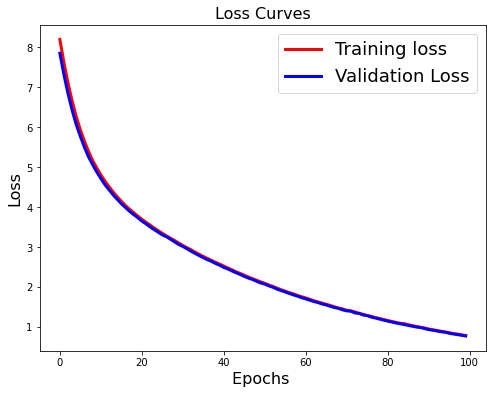

In [41]:
plt_train_val_loss(history)

In [42]:
#Plot the Accuracy Curves
def plt_train_val_accuracy(history):
  plt.figure(figsize=[8,6])
  plt.plot(history.history['accuracy'],'r',linewidth=3.0)
  plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16)

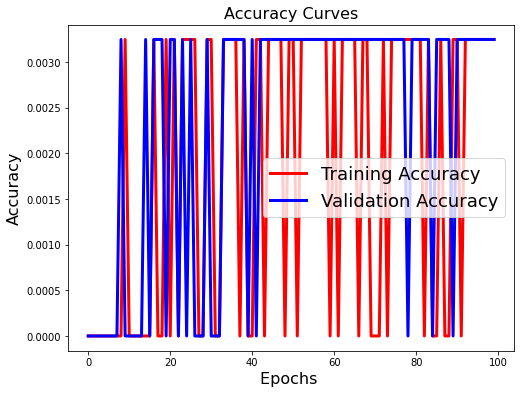

In [43]:
plt_train_val_accuracy(history)

In [44]:
def moving_test_window_preds(scaled_dataset, window_size, model, n_future_preds, scaler):
    ''' n_future_preds - number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    preds_moving = []
    # moving_test_window = [train_X[len(train_X) - 1, :].tolist()]
    # moving_test_window = np.array(moving_test_window)
    moving_test_window = scaled_dataset[-window_size:].values.reshape(1,window_size,1)

    for i in range(n_future_preds):
      preds_one_step = model.predict(moving_test_window)
      preds_moving.append(preds_one_step[0, 0])
      preds_one_step = preds_one_step.reshape(1, 1, 1)
      moving_test_window = np.concatenate((moving_test_window[:, 1:, :], preds_one_step), axis=1)
    preds_moving = scaler.inverse_transform(np.array(preds_moving).reshape(n_future_preds, 1))
    preds_moving = preds_moving[1:]
    return preds_moving

In [45]:
predictions = moving_test_window_preds(series, 12, univariate_forecast_model,
                                                   24, scaler)

In [46]:
def create_future_dataframe(dataset,forecast_range,future_freq,predictions):
  last_date = dataset.index[-1]  # need to be change (to get next day of last_date)
  data = pd.date_range(last_date, periods = forecast_range-1,freq = future_freq)
  col = {'Date':data}
  pred_df = pd.DataFrame(data = col)
  pred_df['SalesVolume'] = predictions
  return pred_df

In [47]:
forecasted_dataset = create_future_dataframe(df, 24, 'MS', predictions)

In [48]:
forecasted_dataset.head()

,Date,SalesVolume
0,2021-08-01,52184.765625
1,2021-09-01,49130.929688
2,2021-10-01,50344.457031
3,2021-11-01,44859.851562
4,2021-12-01,39697.953125


In [49]:
final_df = df.reset_index().append(forecasted_dataset[1:])

In [50]:
final_df.tail()

,Date,SalesVolume
18,2023-02-01,60757.531250
19,2023-03-01,56413.468750
20,2023-04-01,49355.929688
21,2023-05-01,42248.515625
22,2023-06-01,38745.152344


In [51]:
fig = px.line(final_df, x='Date', y="SalesVolume")
fig.show()

In [94]:
final_df['Date'] = pd.DatetimeIndex(final_df['Date'])
final_df = final_df.groupby('Date').sum()

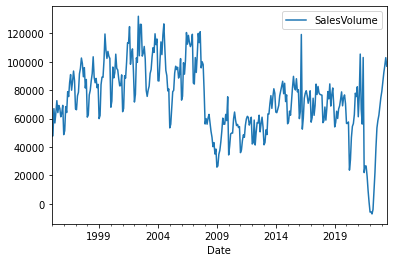

In [95]:
final_df.plot()